In [1]:
from scipy import ndimage
import cv2
import os
import random
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pkl_file = open('/content/drive/MyDrive/myfile.pkl', 'rb')
fft_images = pickle.load(pkl_file)
pkl_file.close()

In [4]:
!cp -r /content/drive/MyDrive/scan_doc_rotation .

In [5]:
path = 'scan_doc_rotation'
names = [file for file in os.listdir(f'{path}/images/') ]
names = sorted(names)
N = len(names)

In [6]:
label_names = [file for file in os.listdir(path+'/labels') ]
label_names = sorted(label_names)
M = len(label_names)

labels = [np.loadtxt(path+'/labels/'+label_names[j]) for j in range(M)]
labels = [round(float(labels[j])) for j in range(M)]

# Load first 10 labels
[print(label_names[i], labels[i]) for i in range(10)]
print('Total number of labels', len(labels))

0.txt -2
1.txt 1
10.txt 5
100.txt 5
1000.txt -1
1001.txt 2
1002.txt 4
1003.txt -2
1004.txt 0
1005.txt -3
Total number of labels 2350


In [7]:
# Get images into tensor form

idxs=list(range(len(labels)))
random.shuffle(idxs)

image_arr = [tf.keras.preprocessing.image.img_to_array(fft_images[i]) 
for i in tqdm(range(N))]

# get pixel dimensions of image
img_height = image_arr[0].shape[0]
img_width = image_arr[0].shape[1]

# Training, Validation and test image stacks
length = len(idxs)
train_size=int(.8*length)
val_size=int(.1*length)
test_size=int(.1*length)

train_idxs = idxs[:train_size]
val_idxs = idxs[train_size:train_size+val_size]
test_idxs = idxs[train_size+val_size:]

X_train = tf.stack([image_arr[i] for i in tqdm(train_idxs)], axis=0, name='train_set')
X_val = tf.stack([image_arr[i] for i in tqdm(val_idxs)], axis=0, name='val_set')
X_test = tf.stack([image_arr[i] for i in tqdm(test_idxs)], axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X_train = np.array(X_train).reshape(train_size, pixel_count)
X_val = np.array(X_val).reshape(val_size, pixel_count)
X_test = np.array(X_test).reshape(test_size, pixel_count)

# Normalise pixel values
X_train /= 255
X_val /= 255
X_test /= 255



100%|██████████| 235/235 [00:00<00:00, 786641.21it/s]


In [8]:
# labels
Y_train_ = np.array([labels[i] for i in train_idxs]).reshape(len(train_idxs))
Y_val_ = np.array([labels[i] for i in val_idxs]).reshape(len(val_idxs))
Y_test_ = np.array([labels[i] for i in test_idxs]).reshape(len(test_idxs))

# Check shape of each tensor
print(X_train.shape, Y_train_.shape)
print(X_val.shape, Y_val_.shape)
print(X_test.shape, Y_test_.shape)

(1880, 226400) (1880,)
(235, 226400) (235,)
(235, 226400) (235,)


In [9]:
# Show number of unique labels
classes = np.unique(Y_train_)
print(classes)
n_classes = len(np.unique(Y_train_))

# Create classes from unique labels
Y_train = to_categorical(Y_train_, n_classes)
Y_val = to_categorical(Y_val_, n_classes)
Y_test = to_categorical(Y_test_, n_classes)
print(Y_train.shape, Y_val.shape, Y_test)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(1880, 11) (235, 11) [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [10]:
model = Sequential()

model.add(Dense(512, activation='relu', 
                 input_shape=(pixel_count,)))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(n_classes, activation = 'softmax'))

In [11]:
model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'],
              )

In [12]:
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    # monitor='loss',
    mode='min',
    save_best_only=True)

In [13]:
history = model.fit(X_train, Y_train,validation_data=(X_val, Y_val), batch_size=32, epochs=25, verbose=2,
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/25
59/59 - 13s - loss: 2.8275 - accuracy: 0.0984 - val_loss: 2.4033 - val_accuracy: 0.0809 - 13s/epoch - 225ms/step
Epoch 2/25
59/59 - 9s - loss: 2.4065 - accuracy: 0.1112 - val_loss: 2.3438 - val_accuracy: 0.1574 - 9s/epoch - 160ms/step
Epoch 3/25
59/59 - 9s - loss: 2.2814 - accuracy: 0.1527 - val_loss: 1.9049 - val_accuracy: 0.2426 - 9s/epoch - 155ms/step
Epoch 4/25
59/59 - 10s - loss: 1.9063 - accuracy: 0.2133 - val_loss: 1.7913 - val_accuracy: 0.2638 - 10s/epoch - 162ms/step
Epoch 5/25
59/59 - 9s - loss: 1.4007 - accuracy: 0.3899 - val_loss: 1.3549 - val_accuracy: 0.3404 - 9s/epoch - 160ms/step
Epoch 6/25
59/59 - 4s - loss: 1.0759 - accuracy: 0.5415 - val_loss: 1.4057 - val_accuracy: 0.4511 - 4s/epoch - 62ms/step
Epoch 7/25
59/59 - 9s - loss: 0.9384 - accuracy: 0.5862 - val_loss: 0.7067 - val_accuracy: 0.7574 - 9s/epoch - 156ms/step
Epoch 8/25
59/59 - 4s - loss: 0.7916 - accuracy: 0.6957 - val_loss: 1.4186 - val_accuracy: 0.3617 - 4s/epoch - 60ms/step
Epoch 9/25
59/59 - 4s 

In [14]:
predictions = model.predict(X_test)
max_prob = np.argmax(predictions, axis=1)
print(max_prob)

[ 2 10  9  6 10 10  9 10  4  5  1  6  4  9  9  9  2 10  3  6  3 10 10  5
 10  2  7  9  3 10  9  4 10 10  9  5  9  3  4 10  2 10  7  9  6 10  9 10
  5  7  2  4  9 10  9  4 10  9  7  7  1  6  4  2  2 10 10  2 10 10  7  7
 10  7  9  3  4  2  3  4  4  5  5  7  3  9  7  6  7 10  7 10  5 10 10  5
 10 10  9 10  7  4  2  3  2  3  7 10  3 10  9  9 10  7  6  4  7  7  9  2
 10  3  4  7  9  5  3  7 10  9 10  4 10  6  7  3  9  3 10  9 10  2  2  7
 10  5  9  5  4  2 10 10  7  9  5 10  2  3  9  5  2 10 10  7  7  9  4 10
  3  1  3  5 10  7  9  1 10  2  6  7  3  1 10 10  2  2  4  4  9 10  2  7
  1 10 10  2 10  7  7 10 10 10  4 10  1  6  5  7 10 10  9  6  4  2  9  3
  9 10  4  1 10  9  3  9  2  1  5  7  9  9 10  9  9  4 10]


In [18]:
df = pd.DataFrame({'Image name': [names[i] for i in test_idxs], 'Rotated angle (deg)': classes[max_prob], 'Rotated angle (rad)':classes[max_prob]*3.14/180})
df.head(10)

,Image name,Rotated angle (deg),Rotated angle (rad)
0,1006.png,-3,-0.052333
1,458.png,5,0.087222
2,827.png,4,0.069778
3,763.png,1,0.017444
4,1511.png,5,0.087222
5,506.png,5,0.087222
6,scan_188.png,4,0.069778
7,303.png,5,0.087222
8,scan_307.png,-1,-0.017444
9,1348.png,0,0.000000


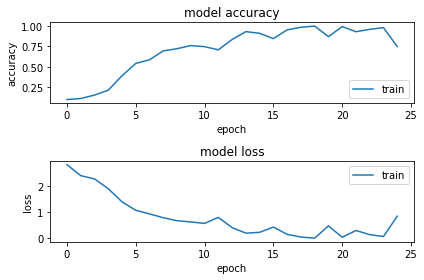

In [16]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()